In [39]:
import os
import cv2
import random
import json
import datetime
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import tensorflow as tf
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)

tensorflow version: 2.3.1


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
######################################################
## seed and defaults
######################################################

seed = 2020
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
    

DATA_DIR = '../../input/osic-pulmonary-fibrosis-progression'
TRAINING = 'train'
TEST = 'test'
TRAIN_FEATURES = [
    'Age',
    'Ex-smoker',
    'Never smoked',
    'Currently smokes',
    'Male',
    'Female'
]
GROUP_SPLITS = 20

IMG_SIZE = 512
DIMS = 1

EPOCHS = 30
BATCH_SIZE = 2
MODEL_NAME = 'linear_no_effent'
MODEL_VERSION = 'v1'
MODEL = MODEL_NAME + '_' + MODEL_VERSION + '_batch_' + str(BATCH_SIZE) + '_epochs_' + str(EPOCHS)
SAVE_BEST = True
LR = 0.1

In [4]:
train = pd.read_csv(DATA_DIR + '/train.csv')
test = pd.read_csv(DATA_DIR + '/test.csv') 
submission = pd.read_csv(DATA_DIR + '/sample_submission.csv') 

submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['Weeks'] = submission['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))

print('Train shape', train.shape)
print('Test shape', test.shape)
print('Submission shape', submission.shape)

Train shape (1549, 7)
Test shape (5, 7)
Submission shape (730, 5)


In [5]:
train_df = train.copy()
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [6]:
## expand categories

def add_col(df, col):
    df[col] = 0

smoking_cats = train_df.SmokingStatus.unique().tolist()
sex = train_df.Sex.unique().tolist()

[add_col(train_df, i) for i in smoking_cats]
[add_col(train_df, i) for i in sex]

for p in train_df.Patient.unique():
    sex_val = train_df.loc[train_df.Patient == p, 'Sex'].values[0]
    train_df.loc[train_df.Patient == p, sex_val] = 1
    
    smoke_stat_val = train_df.loc[train_df.Patient == p, 'SmokingStatus'].values[0]
    train_df.loc[train_df.Patient == p, smoke_stat_val] = 1

In [7]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Ex-smoker,Never smoked,Currently smokes,Male,Female
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,1,0,0,1,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,1,0,0,1,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,1,0,0,1,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,1,0,0,1,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,1,0,0,1,0


In [8]:
## scale age

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_df[['Age']])

train_df['Age'] = min_max_scaler.transform(train_df[['Age']])

train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Ex-smoker,Never smoked,Currently smokes,Male,Female
0,ID00007637202177411956430,-4,2315,58.253649,0.769231,Male,Ex-smoker,1,0,0,1,0
1,ID00007637202177411956430,5,2214,55.712129,0.769231,Male,Ex-smoker,1,0,0,1,0
2,ID00007637202177411956430,7,2061,51.862104,0.769231,Male,Ex-smoker,1,0,0,1,0
3,ID00007637202177411956430,9,2144,53.950679,0.769231,Male,Ex-smoker,1,0,0,1,0
4,ID00007637202177411956430,11,2069,52.063412,0.769231,Male,Ex-smoker,1,0,0,1,0


In [27]:
def get_training_components(df, features):
    patients = df.Patient.unique().tolist()
    coefs = {}
    meta_data = {}

    for i, p in enumerate(patients):
        p_df = train.loc[train.Patient == p, :] 
        c = np.vstack([p_df.Weeks.values, np.ones(len(p_df.Weeks.values))]).T
        coef, _ = np.linalg.lstsq(c, p_df.FVC.values)[0]

        coefs[p] = coef
        meta_data[p] = df[features].values[0]
        
    return patients, coefs, meta_data
    
def get_img(path, img_size):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (img_size, img_size))

def get_model(seed, droput_rate=0.5, noise=0.2, img_size=512, img_dims=1, meta_size=6):
    
    inputs_images = tf.keras.layers.Input(shape=(img_size, img_size, img_dims))
    x_image = tf.keras.layers.Conv2D(32, (3, 3))(inputs_images)
    x_image = tf.keras.layers.Dense(16, activation='relu')(x_image)
    x_image = tf.keras.layers.MaxPooling2D((2, 2))(x_image)
    x_image = tf.keras.layers.Conv2D(64, (3, 3))(x_image)
    x_image = tf.keras.layers.Dense(32, activation='relu')(x_image)
    x_image = tf.keras.layers.MaxPooling2D((2, 2))(x_image)
    x_image = tf.keras.layers.Conv2D(64, (3, 3))(x_image)
    x_image = tf.keras.layers.Dense(4, activation='relu')(x_image)
    x_image = tf.keras.layers.MaxPooling2D((2, 2))(x_image)
    x_image = tf.keras.layers.GlobalAveragePooling2D()(x_image)
    
    
    # meta data
    inp_meta = tf.keras.layers.Input(shape=(meta_size,))
    x_meta = tf.keras.layers.GaussianNoise(noise)(inp_meta)
    
    # combine
    x = tf.keras.layers.Concatenate()([x_image, x_meta]) 
    x = tf.keras.layers.Dropout(droput_rate, seed=seed)(x) 
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model([inputs_images, inp_meta] , x)

    return model

In [28]:
class DataGen(tf.keras.utils.Sequence):
        
    def __init__(self, keys, coefs, meta_data, data_dir, folder, batch_size=6, img_size=512):
        
        self.keys = keys
        self.coefs = coefs
        self.meta_data = meta_data
        self.batch_size = batch_size
        self.img_size = img_size
        self.train_data = {}
        self.data_dir = data_dir
        self.folder = folder

        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'{self.data_dir}/{self.folder}/{p}/')
    
    def __len__(self):
        return int(np.floor(len(self.keys) / self.batch_size))
    
    def __getitem__(self, idx):
        
        ct_slices = []
        coefs, meta_data = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        
        for k in keys:
            i = np.random.choice(self.train_data[k], size=1)[0]
            path = f'{self.data_dir}/{self.folder}/{k}/{i}'
            try:
                img = get_img(path, self.img_size)
                ct_slices.append(img)
                coefs.append(self.coefs[k])
                meta_data.append(self.meta_data[k])
                
            except:
                print('error loading image from patient', k)
       
        ct_slices, coefs, meta_data = np.array(ct_slices), np.array(coefs), np.array(meta_data)
        ct_slices = np.expand_dims(ct_slices, axis=-1)
                
        return [ct_slices, meta_data] , coefs

In [29]:
model = get_model(seed, img_size=IMG_SIZE, img_dims=DIMS, meta_size=len(TRAIN_FEATURES))

In [30]:
## patient will be used for evaluation later
test_patient = random.choice(train_df['Patient'].values)
test_df = train_df.loc[train_df['Patient'] == test_patient]
train_df.drop(train_df[train_df['Patient'].isin([test_patient])].index, inplace = True)
train_df = train_df.reset_index(drop=True)

group_splits = GroupKFold(n_splits=GROUP_SPLITS)
train_df['split'] = -1

for i, (train_idx, val_idx) in enumerate(group_splits.split(train_df, groups=train_df['Patient'])):
    train_df.loc[val_idx, 'split'] = i

val_group = random.sample(range(GROUP_SPLITS), 1)

train_data = train_df.loc[(train_df['split'] != val_group[0])]
val_data = train_df.loc[train_df['split'] == val_group[0]]
    
train_patitents, train_coefs, train_meta_data = get_training_components(train_data, TRAIN_FEATURES)
val_patitents, val_coefs, val_meta_data = get_training_components(val_data, TRAIN_FEATURES)


/home/dev_pool/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [31]:
print('Train data shape:', train_data.shape)
print('Val data shape:', val_data.shape)
print('Test data shape:', test_df.shape)

Train data shape: (1464, 13)
Val data shape: (78, 13)
Test data shape: (7, 12)


In [32]:
log_dir = "logs/fit/" + MODEL + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{MODEL}.h5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)


train_datagen = DataGen(
    keys=np.array(train_patitents), 
    coefs=train_coefs, 
    meta_data=train_meta_data,
    data_dir=DATA_DIR,
    folder=TRAINING,
    batch_size=BATCH_SIZE
)

val_datagen = DataGen(
    keys=np.array(val_patitents), 
    coefs=val_coefs, 
    meta_data=val_meta_data,
    data_dir=DATA_DIR,
    folder=TRAINING,
    batch_size=BATCH_SIZE
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mae') 

history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    callbacks = [checkpoint, rlp, tensorboard_callback], 
    epochs=EPOCHS
)

print('Training done!')

Epoch 1/30
 1/83 [..............................] - ETA: 0s - loss: 1.8026WARNING:tensorflow:From /home/dev_pool/anaconda3/envs/thesis/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
83/83 [==============================] - ETA: 0s - loss: 286.8033
Epoch 00001: val_loss improved from inf to 4.42479, saving model to linear_no_effent_v1_batch_2_epochs_30.h5
83/83 [==============================] - 13s 153ms/step - loss: 286.8033 - val_loss: 4.4248
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 4.4941
Epoch 00002: val_loss did not improve from 4.42479
83/83 [==============================] - 13s 156ms/step - loss: 4.4941 - val_loss: 4.9537
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 4.5157
Epoch 00003: val_loss did not improve from 4.42479
83/83 [======

In [33]:
# save history for later inspection
history_file = f'{MODEL}.txt'
dict_to_save = {}

for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})

with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)

In [34]:
%load_ext tensorboard

In [41]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6481), started 1:14:52 ago. (Use '!kill 6481' to kill it.)

In [37]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 510, 510, 32) 320         input_10[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 510, 510, 16) 528         conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 255, 255, 16) 0           dense_10[0][0]                   
_______________________________________________________________________________________

In [ ]:
_, _, test_meta_data = get_training_components(test_df, TRAIN_FEATURES)

init_week, init_percent, prediction_means, init_week_prediction = {}, {}, {}, {}

for p in test_df.Patient.unique():

    ldir = os.listdir(f'{DATA_DIR}/{TRAINING}/{p}/')
    ct_slices = [] 
    init_meta_data = [] 
    
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
            ct_slices.append(get_img(f'{DATA_DIR}/{TRAINING}/{p}/{i}', IMG_SIZE))
            init_meta_data.append(test_meta_data[p]) 
        if len(ct_slices) <= 1:
            continue

    ## expand to (width, height, depth)
    ct_slices = np.expand_dims(ct_slices, axis=-1)
    init_meta_data = np.array(init_meta_data)

    ## predict the intial based on
    ## each slice in the scan set
    print('Evaluating', p)
    evaluation = model.evaluate([ct_slices, init_meta_data], verbose=1)
    print('Evaluation done...')
    
    print(evaluation)

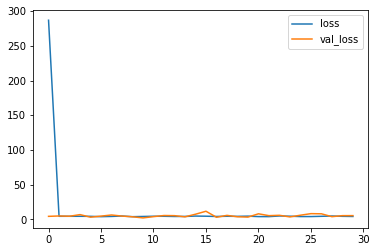

KeyError: 'score'

In [40]:
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['score'][:ep_max], label='score')
plt.plot(history.history['val_score'][:ep_max], label='val score')
plt.legend()
plt.show()